In [118]:
import seaborn as sns
import matplotlib.pyplot as pt
import numpy as np
import pandas as pd
import json
import os

folder_to_experiment_results = "/home/joao/Documentos/repos/renewable-generation-into-reserve-markets/models_validation"

experiments= {
    "exp1":"linear_models_epocs",
    "exp2":"losses_experiment",
}

In [119]:

def get_experiment_results(path_experiment):
    
    files_in_experiment = os.listdir(path_experiment)
    models_in_experiment = [f for f in files_in_experiment if os.path.isdir(os.path.join(path_experiment,f))]
    
    experiment_result_path = os.path.join(path_experiment, [f for f in files_in_experiment if "csv" in f][0])
    
    experiment_result = pd.read_csv(experiment_result_path)
    
    res_df = pd.DataFrame()
    res_dict = {}
    
    losses_dict = {}
    metric_dict = {}
    
    freq_saves_dict = {}
    
    for exp in models_in_experiment:
        results_path = [os.path.join(path_experiment,exp,r)  for r in os.listdir(os.path.join(path_experiment,exp)) if "npz" in r][0]
    
        history_path = results_path.replace("models_validation", "models_trained").replace("_test.npz", "_history.json")
        freq_saves_folder = history_path.replace("_history.json", "freq_saves")
        freq_saves_files =  [os.path.join(freq_saves_folder,r)  for r in os.listdir(freq_saves_folder) if "keras" in r]
        freq_saves_files =  [f for f in freq_saves_files if "unf" not in f]
        freq_saves_dict[exp] = freq_saves_files
        
        with open(history_path) as file:
            history = json.load(file)
        
        metric_name = "root_mean_squared_error"
        metric_dict[f"{exp}"] = history[metric_name]
        
        
        res_np = np.load(results_path)
        for key in res_np.keys():
            if key not in res_df:
                key_name = key
                if key=="prediction":
                    key_name = exp
                res_dict[key_name] = res_np[key]
                res_df[key_name] = res_np[key].ravel()
    
    longer_hist = 0
    for exp, rmse in metric_dict.items():
        if not isinstance(rmse, list):
            rmse = [rmse]
        longer_hist = max(longer_hist, len(rmse))
    
    history_df = pd.DataFrame()
    for exp, rmse in metric_dict.items():
        if not isinstance(rmse, list):
            rmse = [rmse]
        if len(rmse) != longer_hist:
            missing_numbers = longer_hist - len(rmse)
            miss = np.full(missing_numbers, np.nan)
            rmse = np.concatenate([rmse,miss])
        history_df[exp] = rmse

    return experiment_result, res_df, history_df, freq_saves_dict

In [128]:
# Experiment 1

path_experiment = os.path.join(folder_to_experiment_results,experiments["exp1"])
experiment_result, res_df, history_df, freq_saves_dict = get_experiment_results(path_experiment)

In [129]:
experiment_result

,name,rmse,abs erro,erro comp,r2 score,mape score,alloc missing,alloc surplus,spain alloc missing,spain alloc surplus,optimal percentage,better allocation,beter percentage
0,VanillaDense,1200.202796,1.007319e+07,False,-41.274281,192.501436,487.240173,1.007270e+07,57465.0,3831902.4,1.133242,0.766941,1.167582
1,StackedCNN,453.124190,3.717807e+06,True,-5.025616,82.674658,52038.157788,3.665769e+06,57465.0,3831902.4,35.038919,34.478022,38.335623
2,UNET,183.575573,1.166187e+06,True,0.010999,17.023004,687071.632099,4.791153e+05,57465.0,3831902.4,60.393773,60.393773,85.473901
3,VanillaCNN,174.963595,1.124206e+06,True,0.101615,16.451389,614355.897472,5.098498e+05,57465.0,3831902.4,61.790293,61.790293,86.183608


<Axes: >

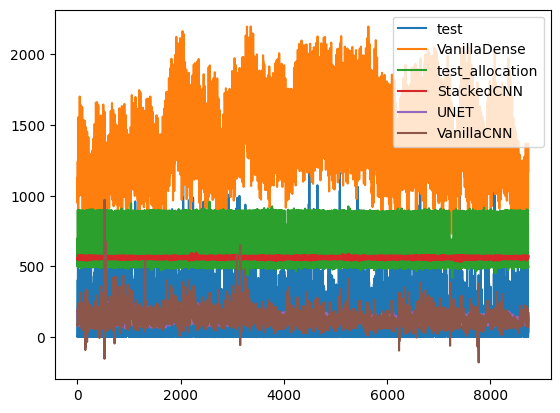

In [121]:
res_df.plot()

In [122]:
results_path

'/home/joao/Documentos/repos/renewable-generation-into-reserve-markets/models_validation/linear_models_epocs/VanillaCNN/VanillaCNN_test.npz'

<Axes: >

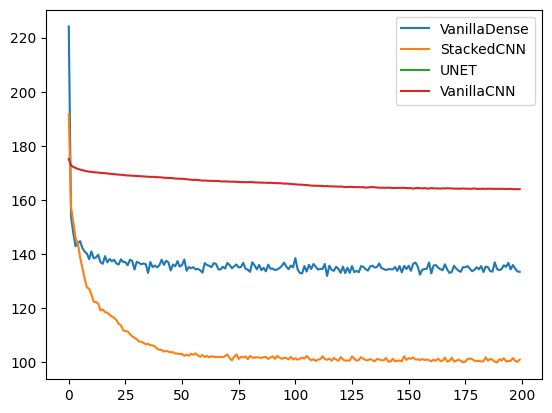

In [123]:
history_df.plot()

<Axes: >

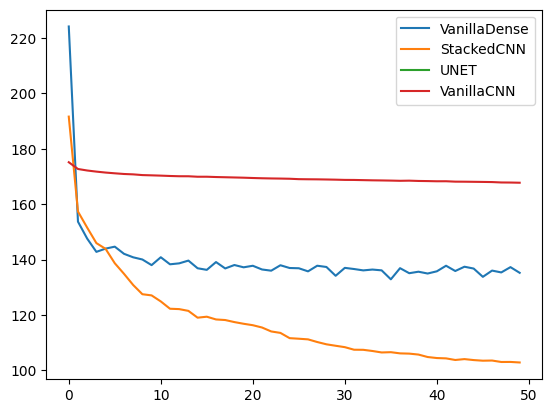

In [124]:
history_df.iloc[:50].plot()

In [125]:
# Podemos ver que todas as rmse estas estagnadas a partir da epoca 50, para ver o impacto das mesmas a nivel dos dados
# Estudemos cada previsao em cada 10 epocas ate 50, e depois de 30 a 30


epocas_study = [f for f in range(0, 50, 10)]
epocas_study2 = [f for f in range(50, 201, 30)]
epocas_study = epocas_study + epocas_study2
epocas_study = epocas_study[1:]

In [126]:
epocas_study

[10, 20, 30, 40, 50, 80, 110, 140, 170, 200]

In [127]:
for exp, freq_list in  freq_saves_dict.items():
    for ep in epocas_study:
        path = [f for f in freq_list if int(os.path.basename(f).replace(".keras", ""))==ep][0]

        break

    break

In [130]:
# Experiment 2

path_experiment = os.path.join(folder_to_experiment_results,experiments["exp2"])
experiment_result, res_df, history_df, freq_saves_dict = get_experiment_results(path_experiment)

In [131]:
experiment_result

,name,rmse,abs erro,erro comp,r2 score,mape score,alloc missing,alloc surplus,spain alloc missing,spain alloc surplus,optimal percentage,better allocation,beter percentage
0,StackedCNNmae,198.291917,1.083872e+06,True,-0.153923,5.925168,9.377863e+05,1.460860e+05,57465.0,3831902.4,43.646978,43.646978,83.321886
1,StackedCNNmape,232.596769,1.257579e+06,True,-0.587721,1.012643,1.252220e+06,5.358456e+03,57465.0,3831902.4,19.150641,19.150641,80.597527
2,StackedCNNmse,176.707601,1.103153e+06,True,0.083616,14.810914,6.731585e+05,4.299941e+05,57465.0,3831902.4,58.745421,58.745421,85.679945
3,StackedCNNwl,2002.807872,1.709211e+07,False,-116.718723,320.210229,0.000000e+00,1.709211e+07,57465.0,3831902.4,0.045788,0.000000,0.045788
4,UNETmae,189.565312,1.096387e+06,True,-0.054593,10.397056,7.860374e+05,3.103499e+05,57465.0,3831902.4,51.934524,51.934524,84.661172
5,StackedCNNmsle,225.424433,1.761315e+06,True,-0.491313,40.411505,3.208133e+05,1.440502e+06,57465.0,3831902.4,79.464286,79.464286,89.926740
6,StackedCNNmsde,612.309644,4.978280e+06,False,-10.002951,81.855094,3.325166e+06,1.653114e+06,57465.0,3831902.4,18.269231,18.063187,30.139652


<Axes: >

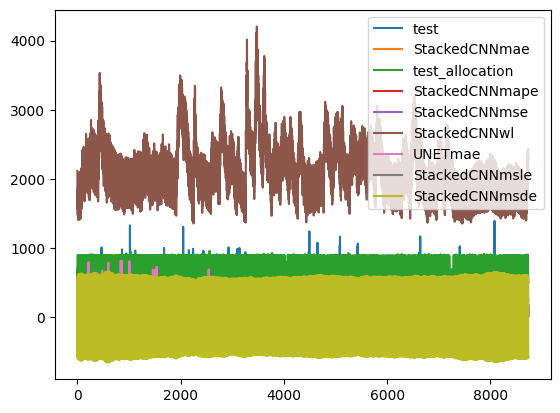

In [133]:
res_df.plot()

<Axes: >

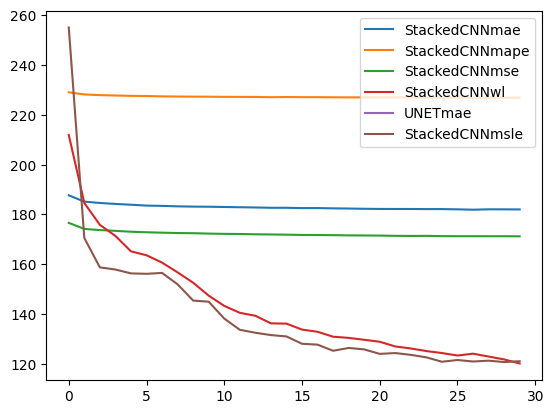

In [138]:
history_df.drop([
    "StackedCNNmsde"
], axis=1).plot()